In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import time

In [ ]:
!pip install watermark --quiet
%load_ext watermark
%watermark -a 'Anrei Sech' -v -p torch

Author: Anrei Sech

Python implementation: CPython
Python version       : 3.7.13
IPython version      : 7.9.0

torch: 1.12.1+cu113



In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 64
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)

# Loading the data

In [ ]:
transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                              torchvision.transforms.ToTensor()])

In [ ]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [ ]:
train_data = torchvision.datasets.ImageFolder("/drive/My Drive/DL/data/hymenoptera_data/train", transformer)
val_data = torchvision.datasets.ImageFolder("/drive/My Drive/DL/data/hymenoptera_data/val", transformer)

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
NUM_CLASSES = len(train_data.classes)
print(train_data.classes)

['ants', 'bees']


## Calculating mean and standard deviation

In [ ]:
def get_mean_and_std(loader):
    mean = std = total_images = 0
    for images, _ in loader:
        images = images.view(images.shape[0], images.shape[1], -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += images.shape[0]
    mean /= total_images
    std /= total_images
    return mean, std

In [ ]:
mean, std = get_mean_and_std(train_loader)
print(mean, std)

tensor([0.5143, 0.4760, 0.3487]) tensor([0.2196, 0.2114, 0.2079])


## Applying mean and std to normalize images and augmentation

In [ ]:
train_transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)), 
                                               #torchvision.transforms.RandomHorizontalFlip(p=0.7), 
                                               #torchvision.transforms.RandomVerticalFlip(),
                                               #torchvision.transforms.RandomCrop((224, 224), scale=(0.1, 1), ratio=(0.5, 2)),
                                               torchvision.transforms.AutoAugment(torchvision.transforms.AutoAugmentPolicy.IMAGENET),
                                               torchvision.transforms.ToTensor(), 
                                               torchvision.transforms.Normalize(mean, std)])

In [ ]:
test_transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((224, 224)),
                                               torchvision.transforms.ToTensor(), 
                                               torchvision.transforms.Normalize(mean, std)])

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=BATCH_SIZE, shuffle=False)

image.shape: torch.Size([64, 3, 224, 224])


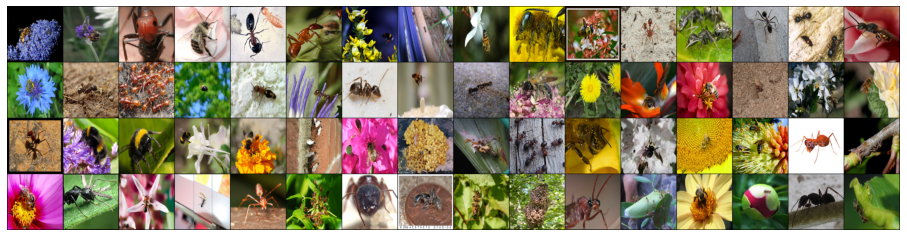

In [ ]:
from torchvision.utils import make_grid
for images, _ in train_loader:
  print('image.shape:', images.shape)
  plt.figure(figsize=(16,8))
  plt.axis('off')
  plt.imshow(make_grid(images, nrow=16).permute(1,2,0))
  break

# VGG model

In [ ]:
def vgg_block(num_convs, input_channels, num_channels):

    block = nn.Sequential(
        nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1),
        nn.ReLU()
    )

    for i in range(num_convs - 1):
        block.add_module("conv{}".format(i),
                         nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
                         )
        block.add_module("relu{}".format(i),
                         nn.ReLU()
                         )

    block.add_module("pool", nn.MaxPool2d(2, stride=2))

    return block

In [ ]:
# Remark: (width/height - kernel_size + 2*padding)/strides + 1 = output_size
import math
block1 = 224
pool1 = math.ceil((block1-3)/2+1)
print(pool1)

block2 = pool1
pool2 = math.ceil((block2-3)/2+1)
print(pool2)

block3 = pool2
pool3 = math.ceil((block3-3)/2+1)
print(pool3)

block4 = pool3
pool4 = math.ceil((block4-3)/2+1)
print(pool4)

block5 = pool4
pool5 = math.ceil((block5-3)/2+1)
print(pool5)

# after flatten
print("After flatten: {}".format(pool5 * pool5 * 512))

112
56
28
14
7
After flatten: 25088


In [ ]:
conv_arch = ((2, 3, 64), (2, 64, 128), (3, 128, 256), (3, 256, 512), (3, 512, 512))

In [ ]:
def vgg(conv_arch):
    net = nn.Sequential()

    for i, (num_convs, input_ch, num_channels) in enumerate(conv_arch):
        net.add_module("block{}".format(i), vgg_block(num_convs, input_ch, num_channels))

    
    classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(25088, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, 4096), nn.ReLU(), nn.Dropout(0.5),
        nn.Linear(4096, NUM_CLASSES))

    net.add_module('classifier', classifier)
    return net

#net = vgg(conv_arch)

In [ ]:
x = train_data[0][0].reshape(1,3,224,224)
#for l in net:
#    print(l, "\t\t", x.shape)

In [ ]:
class VGG16(nn.Module):
    def __init__(self):
        super(VGG16, self).__init__()
        self.net = vgg(conv_arch)

    def forward(self, x):
        return self.net(x)  

In [ ]:
NUM_EPOCHS = 20

In [ ]:
def evaluate_accuracy(data_iter, net):
    acc_sum, n = torch.Tensor([0]).to(DEVICE), 0
    net.eval()
    for X, y in data_iter:
        X = X.to(DEVICE)
        y = y.to(DEVICE)
        acc_sum += (net(X).argmax(axis=1) == y).sum()
        n += y.shape[0]
    return acc_sum.item() / n

In [ ]:
def train(net, train_iter, test_iter, trainer, num_epochs):
    loss = nn.CrossEntropyLoss(reduction='sum')
    net.train()
    for epoch in range(num_epochs):
        train_l_sum, train_acc_sum, n, start = 0.0, 0.0, 0, time.time()
        for X, y in train_iter:
            X = X.to(DEVICE)
            y = y.to(DEVICE)
            trainer.zero_grad()
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            train_l_sum += l.item()
            train_acc_sum += (y_hat.argmax(axis=1) == y).sum().item()
            n += y.shape[0]
            print("Step. time since epoch: {:.3f}. Train acc: {:.3f}. Train Loss: {:.3f}".format(time.time() -  start,
                                                                                                 (y_hat.argmax(axis=1) == y).sum().item() / y.shape[0],
                                                                                                 l.item()))
        test_acc = evaluate_accuracy(test_iter, net)
        print('epoch {:d}, loss {:.4f}, train acc {:.3f}, test acc {:.3f}, time {:.1f} sec'.format(epoch + 1, train_l_sum / n,
                                                                                                    train_acc_sum / n, test_acc,
                                                                                                    time.time() - start))

In [ ]:
model = VGG16().to(DEVICE)

In [ ]:
trainer = torch.optim.SGD(model.parameters(), lr=1e-5, momentum=0.9)
train(model, train_loader, val_loader, trainer, NUM_EPOCHS)

Step. time since epoch: 1.432. Train acc: 0.609. Train Loss: 41.815
Step. time since epoch: 2.833. Train acc: 0.672. Train Loss: 41.253
Step. time since epoch: 4.295. Train acc: 0.672. Train Loss: 41.835
Step. time since epoch: 5.491. Train acc: 0.673. Train Loss: 33.138
epoch 1, loss 0.6477, train acc 0.656, test acc 0.595, time 7.1 sec
Step. time since epoch: 1.422. Train acc: 0.641. Train Loss: 42.271
Step. time since epoch: 2.874. Train acc: 0.641. Train Loss: 39.931
Step. time since epoch: 4.366. Train acc: 0.766. Train Loss: 41.999
Step. time since epoch: 5.568. Train acc: 0.615. Train Loss: 33.786
epoch 2, loss 0.6475, train acc 0.668, test acc 0.588, time 7.1 sec
Step. time since epoch: 1.449. Train acc: 0.641. Train Loss: 42.791
Step. time since epoch: 2.872. Train acc: 0.703. Train Loss: 42.124
Step. time since epoch: 4.316. Train acc: 0.672. Train Loss: 40.113
Step. time since epoch: 5.595. Train acc: 0.712. Train Loss: 32.761
epoch 3, loss 0.6467, train acc 0.680, test acc 

# SAVE and LOAD model

In [ ]:
torch.save(model.state_dict(), "vgg16_from_scratch.pkl")

In [ ]:
recovered_model = VGG16()

In [ ]:
recovered_model.load_state_dict(torch.load("vgg16_from_scratch.pkl"))

<All keys matched successfully>

In [ ]:
recovered_model.eval()

In [ ]:
recovered_model.to(DEVICE)

In [ ]:
evaluate_accuracy(val_loader, recovered_model)

0.5751633986928104